# Using calibra to evaluate the reliability of your machine learning model

### Generate synthetic data for a binary classification problem

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=1000, n_features=10, n_informative=6, n_redundant=4, n_clusters_per_class=2, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Fit two models to compare performance and reliability

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

lr = LogisticRegression().fit(X_train, y_train)
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

print(f'Logistic regression accuracy: {100 * lr.score(X_test, y_test): .2f}%')
print(f'Random Forest accuracy: {100 * rf.score(X_test, y_test): .2f}%')

Logistic regression accuracy:  79.33%
Random Forest accuracy:  88.67%


### Now evaluate calibration of each model

In [3]:
from calibra.errors import classwise_ece 

y_pred_proba_lr = lr.predict_proba(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)

classwise_ece_lr = classwise_ece(y_pred=y_pred_proba_lr, y_true=y_test)
classwise_ece_rf = classwise_ece(y_pred=y_pred_proba_rf, y_true=y_test)

print(f'Logistic Regression class-wise expected calibration error {100 * classwise_ece_lr: .2f}%')
print(f'Random Forest class-wise expected calibration error {100 * classwise_ece_rf: .2f}%')

Logistic Regression class-wise expected calibration error  8.12%
Random Forest class-wise expected calibration error  7.99%


In this example, not only does the Random Forest model outperform the logistic regression model, but it is also the more reliable of the two models. 

## Let's visualise the reliability of each model with a calibration curve.

In [4]:
import matplotlib.pyplot as plt
from calibra.plotting import CalibrationCurve

calibration_curve_lr = CalibrationCurve(y_pred=y_pred_proba_lr, y_true=y_test)
calibration_curve_rf = CalibrationCurve(y_pred=y_pred_proba_rf, y_true=y_test)

# By default we split the predictions into 20 bins, but any number of bins can be specified by the num_bins argument in CalibrationCurve 

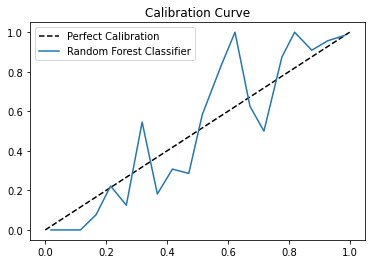

In [5]:
# Now let's visualise the calibration of the Random Forest model
# we can pass in any matplotlib.pyplot.plot() kwargs we want, e.g. label

calibration_curve_rf.plot(label='Random Forest Classifier')
plt.title('Calibration Curve')
plt.legend()

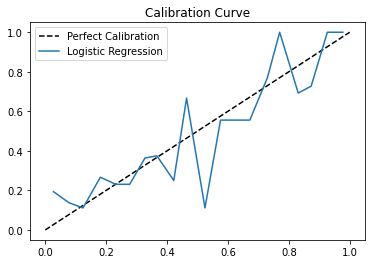

In [6]:
# plot the calibration curve of the Logistic Regression model

calibration_curve_lr.plot(label='Logistic Regression')
plt.title('Calibration Curve')
plt.legend()

The graphs above show the calibration of the models, comparing them against a benchmark of perfect calibration

This highlights the areas where the model may be miscalibrated - and therefore, where predictions may be less reliable

However, the predictions are not necessarily distributed uniformly along the curve, and so the impact of miscalibration at different points on the curve is likely different

Therefore, visualing the miscalibration in this way might be misleading

For instance, the logistic regression model appears highly miscalibrated for predictions around 40-50%. However, if only a small minority of model predictions are actually in this region, the impact of these predictions on overall model reliability should not be large

## Let's plot the curves again, this time, highlighting the density of predictions at each point along the curve by its colour

Text(0.5, 1.0, 'Density-based Calibration Curve')

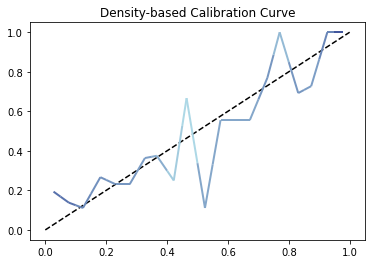

In [7]:
# plot the calibration curve of the Logistic Regression model, highlighting the density at each point by the colour of the curve (by setting show_density=True)
# (where density refers to the weight of the given bin)

calibration_curve_lr.plot(show_density=True)
plt.title('Density-based Calibration Curve')

In the above diagram, the colour of the curve is a function of the density at that point of the curve, where higher density is reflected by stronger colour.

We can see by the light shade of blue that 40-50% is a low-density region

This means there are not very many data points, relatively speaking, whose predicted probabilities lie in this region

To confirm this, let's directly examine the weight of each bin

In [8]:
# The weight of a bin is the proportion of the overall data set whose predictions lie in that bin 
# We can directly extract the weight of the bins for a given set of predictions
# By default, we use 20 bins - this is modifiable

from calibra.utils import bin_probabilities, get_classwise_bin_weights

lr_bins = bin_probabilities(y_pred=y_pred_proba_lr, y_true=y_test)
lr_bin_weights = get_classwise_bin_weights(bins=lr_bins)

# lr_bin_weights is a numpy array of shape (num_classes, num_samples)
# To view the weights for a given class, let's take that row of the array by specifying the class_label as the index
# Since we did not specify a class label when plotting the curves, by default we plotted the curves for class_label=0 (the negative class)

class_label = 0
neg_class_bin_weights = lr_bin_weights[class_label]
print(neg_class_bin_weights)

[0.10333333 0.09666667 0.06       0.05       0.04333333 0.04333333
 0.03666667 0.02666667 0.01333333 0.01       0.03       0.03
 0.03       0.03       0.04333333 0.02       0.04333333 0.03666667
 0.06333333 0.19      ]


Since there are 20 bins into which the predictions are grouped, the indices of the bins at 40-45% and 45-50% are 8 and 9 respectively.

In [9]:
print(neg_class_bin_weights[8:10])

[0.01333333 0.01      ]


As suggested by the light shade of blue shown for this region of the curve, the bins from 40-50% contain a very small proportion of the overall dataset, (approximately 2%)

Note: by default, we colour the curve as a function of the weight of each bin, first normalising the bin weights logarithmically, to emphasise differences at the lower end of the scale.
This can be changed to linear normalisation by setting normalization_type='linear' when calling plot(). Weights are normalised between vmin and vmax (default values of 0.01 and 1). Values below vmin are clipped to vmin.

# The multi-class problem

In [10]:
# repeat the problem for the 3-class case 

X, y = make_classification(n_samples=1000, n_features=10, n_informative=6, n_redundant=4, n_clusters_per_class=2, n_classes=3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Fit two models to compare performance and reliability

In [11]:
lr = LogisticRegression().fit(X_train, y_train)
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

print(f'Logistic regression accuracy: {100 * lr.score(X_test, y_test): .2f}%')
print(f'Random Forest accuracy: {100 * rf.score(X_test, y_test): .2f}%')

Logistic regression accuracy:  62.00%
Random Forest accuracy:  83.00%


### Now evaluate calibration of each model

In [12]:
y_pred_proba_lr = lr.predict_proba(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)

classwise_ece_lr = classwise_ece(y_pred=y_pred_proba_lr, y_true=y_test)
classwise_ece_rf = classwise_ece(y_pred=y_pred_proba_rf, y_true=y_test)

print(f'Logistic Regression class-wise expected calibration error {100 * classwise_ece_lr: .2f}%')
print(f'Random Forest class-wise expected calibration error {100 * classwise_ece_rf: .2f}%')

Logistic Regression class-wise expected calibration error  8.58%
Random Forest class-wise expected calibration error  8.93%


While the random forest still achieves a better accuracy than the logistic regression model, for the 3 class problem, we can see that the logistic regression model is more well-calibrated. 

We can also look at the calibration error achieved across individual classes. This may be useful for situations where we care more about the calibration of a particular class than that of other classes.

In [13]:
overall_error_lr, classwise_errors_lr = classwise_ece(y_pred=y_pred_proba_lr, y_true=y_test, return_classwise_errors=True)
overall_error_rf, classwise_errors_rf = classwise_ece(y_pred=y_pred_proba_rf, y_true=y_test, return_classwise_errors=True)

print('Logistic Regression per class errors - class 0: {}%, class 1: {}%, class 2: {}%'.format(
    round(100 * classwise_errors_lr[0], 2),
    round(100 * classwise_errors_lr[1], 2),
    round(100 * classwise_errors_lr[2], 2), 
))

print('Random Forest per class errors - class 0: {}%, class 1: {}%, class 2: {}%'.format(
    round(100 * classwise_errors_rf[0], 2),
    round(100 * classwise_errors_rf[1], 2),
    round(100 * classwise_errors_rf[2], 2), 
))

Logistic Regression per class errors - class 0: 7.54%, class 1: 7.71%, class 2: 10.51%
Random Forest per class errors - class 0: 8.8%, class 1: 6.94%, class 2: 11.06%


### Compare calibration across each class visually

In [14]:
calibration_curve_lr = CalibrationCurve(y_pred_proba_lr, y_test)

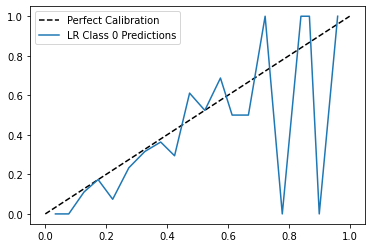

In [15]:
calibration_curve_lr.plot(class_label=0, label='LR Class 0 Predictions')
plt.legend()

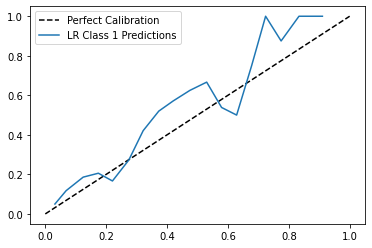

In [16]:
calibration_curve_lr.plot(class_label=1, label='LR Class 1 Predictions')
plt.legend()

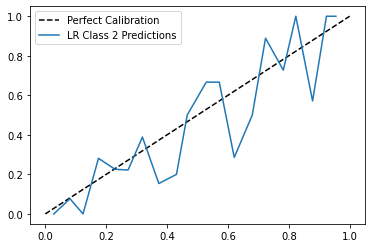

In [17]:
calibration_curve_lr.plot(class_label=2, label='LR Class 2 Predictions')
plt.legend()

### Final Note:

When show_density=True, matplotlib.pyplot **kwargs not currently available when plotting a calibration curve.